# Version information

In [1]:
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: June 30, 2022
Pyleecan version:1.4.0
SciDataTool version:2.4.9


# Bayesian optimization in Pyleecan

This tutorial explains how to use Pyleecan to solve **constrained global optimization** problem using bayesian optimization.

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/).  

For optimization, pyleecan separates problem definition and solver definition. [Another tutorial](https://pyleecan.org/tuto_Optimization.html) already details how to setup the problem to optimize a machine with NSGA-II. 

Pyleecan offers a great flexibility in the evaluation/constraints/design variable definition. To demonstration this flexibility, the problem of this tutorial uses a custom evaluation method is defined to completly skip the calls to pyleecan simulation/models to simulate the Zitzler–Deb–Thiele's function N.3. The project from this tutorial and from the NSGA-II one can be interverted in both notebook.

## Problem definition

The object [**OptiProblem**](https://www.pyleecan.org/pyleecan.Classes.OptiObjFunc.html) contains all the optimization problem characteristics:  

- the evaluation method and the simulation/machine object
- the design variable to vary some parameters of the simulation (e.g. input current, topology of the machine)  
- the objective functions to minimize for the simulation  
- some constraints (optional)  

### Reference simulation definition

To define the problem, we first define a reference simulation and an evaluation function. Each optimization evaluation will copy the reference simulation, set the value of the design variables and call the evaluation function on the simulation.
In this particular example, the evaluation method won't call the run method of the simulation. We pick arbitraly two parameters from the simulation to store the input and 2 parameters from the output to store the results. So the simulation itself doesn't maters.

In [2]:
%matplotlib inline
import numpy as np
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent

# Create the Simulation without machine
simu_ref = Simu1(name="Tuto_Opti_Bayes", machine=None)   

# Defining Simulation Input
Ir= np.zeros(30)  # Ir will be the design variables
simu_ref.input = InputCurrent(Ir=Ir)

# No models
simu_ref.elec = None
simu_ref.mag = None
simu_ref.force = None
simu_ref.struct = None 

# Evaluation function for Zitzler–Deb–Thiele's function N.3
# Using Ir as input, Tem_av and Tem_rip_norm as output
def evaluate_fct(output):
    x = output.simu.input.Ir.value
    f1 = lambda x: x[0]
    g = lambda x: 1 + (9 / 29) * np.sum(x[1:])
    h = lambda f1, g: 1 - np.sqrt(f1 / g) - (f1 / g) * np.sin(10 * np.pi * f1)
    output.mag.Tem_av = f1(x)
    output.mag.Tem_rip_norm = g(x) * h(f1(x), g(x))

### Minimization problem definition

To setup the optimization problem, we define some objective functions using the [**OptiObjective**](https://www.pyleecan.org/pyleecan.Classes.OptiObjective.html) object (which behave the same way as [**DataKeeper**](https://www.pyleecan.org/pyleecan.Classes.DataKeeper.html)). 

Each objective function is stored in the *keeper* attribute of a **OptiObjective**. keeper is a function and can be set either with a string (mandatory to be able to save the object) or directly with a function (the function will be discarded when saving). This type of function takes an output object in argument and returns a float to **minimize**. 

We gather the objective functions into a list:

In [4]:
from pyleecan.Classes.OptiObjective import OptiObjective
import numpy as np

# Evalution fct results are stored in Tem_av and Tem_rip_norm
objs = [
    OptiObjective(
        symbol="obj1",
        name="Objective 1",
        keeper="lambda output: output.mag.Tem_av",
    ),
    OptiObjective(
        symbol="obj2",
        name="Objective 2",
        keeper="lambda output: output.mag.Tem_rip_norm",
    ),
]

### Design variables
We use the object [**OptiDesignVar**](https://www.pyleecan.org/pyleecan.Classes.OptiDesignVar.html) to define the design variables. 


To define a design variable, we have to specify different attributes:  

- *name* to define the design variable name
- *symbol* to access to the variable / for plot (must be unique)
- *unit* to define the variable unit
- *type_var* to specify the variable "type":  
    - *interval* for continuous variables  
    - *set* for discrete variables  
- *space* to set the variable bound
- *setter* to access to the variable in the simu object. This attribute **must begin by "simu"**.  
- *get_value* to define the variable for the first generation, the function takes the space in argument and returns the variable value  

We store the design variables in a list. For this example, we define 30 design variables that changes each element of the Ir array between 0 and 1:   

In [5]:
from pyleecan.Classes.OptiDesignVar import OptiDesignVar
import random

my_vars = []

def gen_setter(i):
    def new_setter(simu, value):
        simu.input.Ir.value[i] = value

    return new_setter

for i in range(30):
    my_vars.append(
        OptiDesignVar(
            name="Ir({})".format(i),
            symbol="var_" + str(i),
            type_var="interval",
            space=[0, 1],
            get_value=lambda space: np.random.uniform(*space),
            setter=gen_setter(i),
        )
    )



### Constraints

The class [**OptiConstraint**](https://www.pyleecan.org/pyleecan.Classes.OptiConstraint.html) enables to define some constraint. For each constraint, we have to define the following attributes:  

- name  
- type_const: type of constraint  
    - "=="  
    - "<="  
    - "<"  
    - ">="  
    - ">"  
- value: value to compare  
- get_variable: function which takes output in argument and returns the constraint value  

We also store the constraints into a dict.

In [6]:
from pyleecan.Classes.OptiConstraint import OptiConstraint

# Constraint on objective 2
my_constraint = [
    OptiConstraint(
        name = "const1",
        type_const = "<=",
        value = 700,
        get_variable = "lambda output: abs(output.mag.Tem_rip_pp)",
    )
]

### Evaluation function


We can create our own evaluation function if needed by defining a function which only take an output in argument. 


In [7]:
from pyleecan.Classes.OptiProblem import OptiProblem

### Defining the problem
my_prob = OptiProblem(
    simu=simu_ref, design_var=my_vars, obj_func=objs, eval_func=evaluate_fct
)

## Solver

Pyleecan separes the problem and solver definition to be able to create different solver that uses the same objects. 

The class [**OptiBayesAlgSmoot**]() enables to solve our problem using Gaussian processes to create a modelization of the machine. The algorithm takes several parameters:  

|Parameter|Description|Type|Default Value|  
| :-: | :- | :-: | :-: |  
|*problem*|Problem to solve|**OptiProblem**|mandatory|
|*nb\_start*|Number of points to start the Gaussian Process|**int**|30|  
|*nb\_iter*|Number of iteration|**int**|5|   
|*nb\_gen*|Generation number|**int**|10|  
|*size\_pop*| Population size per generation|**int**|10| 

  
The `solve` method performs the optimization and returns an [**OutputMultiOpti**](https://www.pyleecan.org/pyleecan.Classes.OutputMultiOpti.html) object which contains the results.

In [8]:
from pyleecan.Classes.OptiBayesAlgSmoot import OptiBayesAlgSmoot
# Solve problem with Bayes
solver = OptiBayesAlgSmoot(problem=my_prob, nb_start=300, nb_iter=10, nb_gen=100, size_pop=40)
res = solver.solve()

15:58:34 Starting optimization...
	Number of iterations: 10
	
iteration 1
PI max value : 1.0
xopt : [2.00701633e-04 6.18115524e-02 7.94555959e-01 3.78517635e-02
 1.03653425e-01 4.89857151e-01 4.22412930e-01 4.14815316e-02
 6.94958181e-01 4.16222585e-01 1.86576720e-02 4.76662655e-01
 5.34459509e-01 7.01383925e-02 1.85794311e-01 1.11961498e-01
 1.61244110e-01 1.01960377e-01 9.02375066e-02 3.24564948e-02
 9.36381523e-02 3.48217312e-01 6.89375537e-01 1.58649534e-01
 4.20985393e-01 4.09177263e-01 9.02469712e-01 4.59098181e-01
 1.76708810e-01 6.97045976e-01]
iteration 2
PI max value : 0.9999999999999137
xopt : [0.61816741 0.28881158 0.50281003 0.29007388 0.36588846 0.35382138
 0.41284226 0.45375008 0.36804241 0.19160352 0.34556654 0.28761034
 0.32661416 0.52449134 0.21700144 0.38645124 0.20139883 0.43603519
 0.38243428 0.45826465 0.46519012 0.43088673 0.53903963 0.32884079
 0.21034388 0.326746   0.35724385 0.34233888 0.2955586  0.15776635]
iteration 3
PI max value : 0.9964295402676556
xopt :

During the algorithm the object displays some data containing:

- number of errors: failure during the objective function execution
- number of infeasible: number of individual with constraints violations

## Plot results

**OutputMultiOpti** has several methods to display some results:  

- `plot_generation`: to plot individuals for in 2D  
- `plot_pareto`: to plot the pareto front in 2D    

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Figure size 432x288 with 0 Axes>

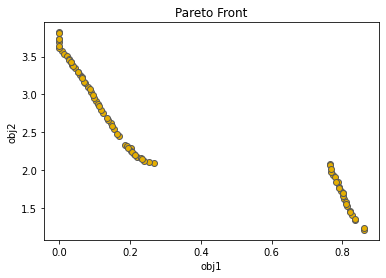

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt 

# Create a figure containing 4 subfigures (axes) 
fig = plt.figure()

# Plot pareto front in fitness space 
res.plot_pareto(
    x_symbol = "obj1", 
    y_symbol = "obj2", 
    is_show_fig=True
)

fig.tight_layout()